In [1]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter('ignore')

from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import torch
from gluonts.torch.distributions.studentT import StudentTOutput
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

In [2]:
def _get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    # Load the checkpoint with map_location set to 'cpu'
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the estimator with the required arguments
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0005,
        
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

         # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (32 + prediction_length) / estimator_args["context_length"]),
        # },
        
        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )


    # Create the lightning module, transformation, and predictor
    # lightning_module = estimator.create_lightning_module()
    # transformation = estimator.create_transformation()
    # predictor = estimator.create_predictor(transformation, lightning_module)
    predictor = estimator.train(dataset, cache_data=True, shuffle_buffer_length=1000)

    # Generate forecasts and time series predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss ,predictor


In [3]:
df = pd.read_csv('input/sales_data4.csv')
col=['ALL_DATE','Region','SKU','QTY']
df.columns=col
df["ALL_DATE"]=pd.to_datetime(df["ALL_DATE"],format="%d-%m-%Y")
df.set_index("ALL_DATE", inplace=True)

In [4]:
df.head()

,Region,SKU,QTY
ALL_DATE,,,
2021-01-01,Hyderabad,SKU1,768.13
2021-02-01,Hyderabad,SKU1,802.64
2021-03-01,Hyderabad,SKU1,879.21
2021-04-01,Hyderabad,SKU1,131.58
2021-05-01,Hyderabad,SKU1,123.08


In [5]:
df=df[['QTY']]

In [6]:
df.shape

(36, 1)

In [7]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset


backtest_dataset = _get_lag_llama_dataset(dataset=df)

In [8]:
train_df=df[:33]
train_dataset = _get_lag_llama_dataset(dataset=train_df)
prediction_length =3 # prediction length
train_samples = train_df.shape[0] # sampled from the distribution for each timestep

test_df=df[33:]
test_dataset = _get_lag_llama_dataset(dataset=test_df)
prediction_length =3 # prediction length
test_samples = train_df.shape[0] # sampled from the distribution for each timestep

In [9]:
forecasts, tss,predictor = _get_lag_llama_predictions(
    train_dataset, prediction_length, train_samples
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.48458 (best 7.48458), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\Forecast-UserInterface\\lightning_logs\\version_2\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.63107 (best 6.63107), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\Forecast-UserInterface\\lightning_logs\\version_2\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.78340 (best 5.78340), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\Forecast-UserInterface\\lightning_logs\\version_2\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.58416 (best 5.58416), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\Forecast-UserInterface\\lightn

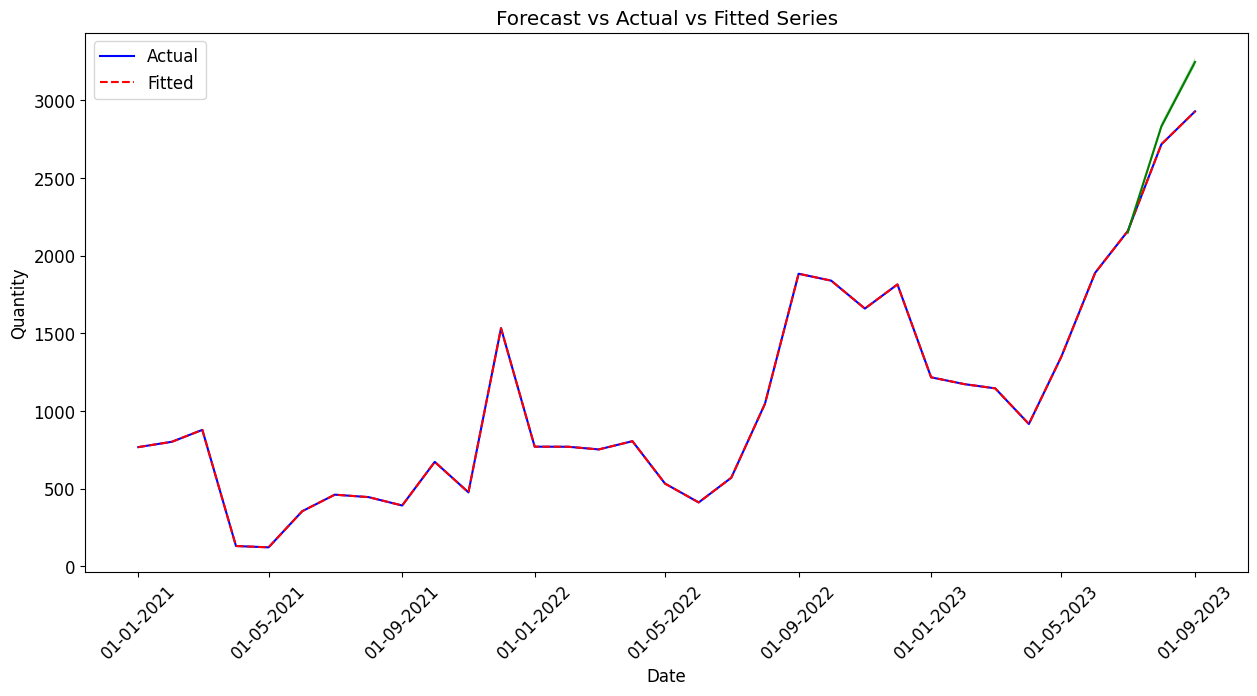

Forecasted Values: [2150.4548 2836.2383 3248.8901]


In [10]:
plt.figure(figsize=(15, 7))
date_formatter = mdates.DateFormatter("%d-%m-%Y")
plt.rcParams.update({"font.size": 12})

ts = tss[0]
forecast = forecasts[0]
fitted_values = ts[:36]

plt.plot(ts.to_timestamp(), label="Actual", color='blue')
plt.plot(fitted_values.to_timestamp(), label="Fitted", color='red',linestyle='--')
forecast.plot(color="green")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.legend()
plt.title("Forecast vs Actual vs Fitted Series")

plt.show()

forecasted_values = forecast.samples.mean(axis=0)
print("Forecasted Values:", forecasted_values)
#print("Fitted Values:", fitted_values.values)

In [11]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,
        predictor=predictor,
        num_samples=test_samples
    )

In [15]:
from tqdm import tqdm  # Ensure you import tqdm properly

In [16]:
forecasts = list(tqdm(forecast_it, total=len(test_dataset), desc="Forecasting batches"))

Forecasting batches: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


In [17]:
tss = list(tqdm(ts_it, total=len(test_dataset), desc="Ground truth"))

Ground truth: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


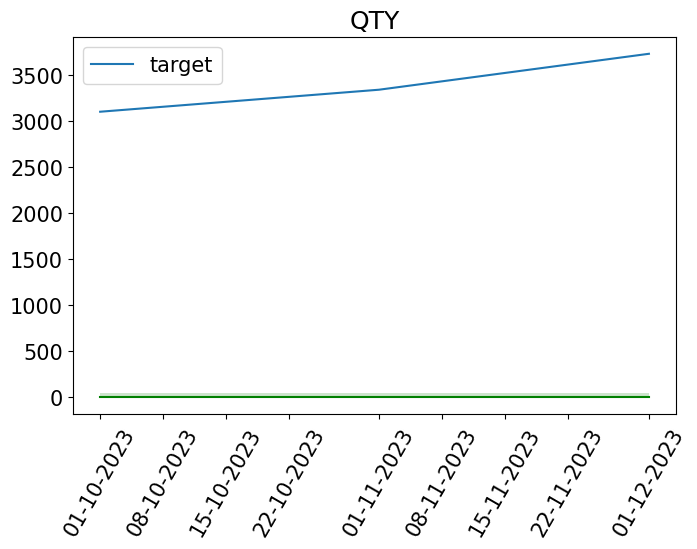

In [18]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%d-%m-%Y")
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
mae = round(agg_metrics['abs_error'],2)
mape = round(agg_metrics['MAPE']*100,2)
rmse = round(agg_metrics['RMSE'],2)
print("Lag LLama MAE: ",mae)
print("Lag LLama MAPE: ",mape)
print("Lag LLama RMSE: ",rmse)